In [1]:
import tensorflow as tf
from utils_plot import plot_series, plot_train_history, plot_prediction
print(tf.__version__)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

2.0.0-beta1


/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

## Load data

In [2]:
import numpy as np
import pandas as pd

df_impressionist_sorted = pd.read_csv('impressionsist_sorted.csv')
impressionist_sorted_matrix = np.load('impressionist_sorted_matrix.npy')

In [3]:
time = np.arange(impressionist_sorted_matrix.shape[0])

## Split dataset

**Define window size**

In [4]:
split_time = 4500
time_train = time[:split_time]
x_train = impressionist_sorted_matrix[:,0][:split_time]
time_valid = time[split_time:]
x_valid = impressionist_sorted_matrix[:,0][split_time:]

window_size = 20
batch_size = 256
shuffle_buffer_size = 1000

**Normalize data**

In [ ]:
x_train_mean = x_train.mean()
x_train_std = x_train.std()

In [ ]:
x_train_norm = (x_train-x_train_mean)/x_train_std

**Plot one window data** 

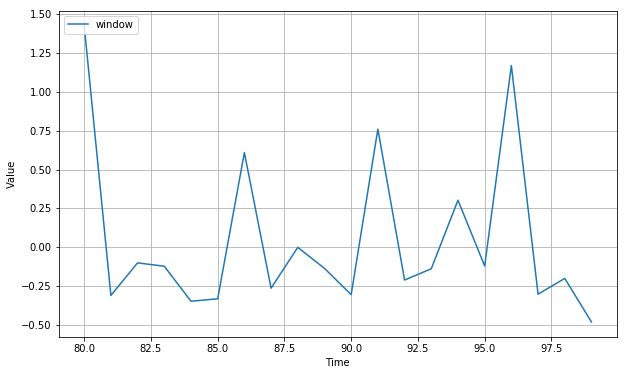

In [6]:
i = 4
plot_series(time_train[window_size*i:window_size*(i+1)], [x_train[window_size*i:window_size*(i+1)]], label='window')

**Create windowed dataset**

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

**Plot example**

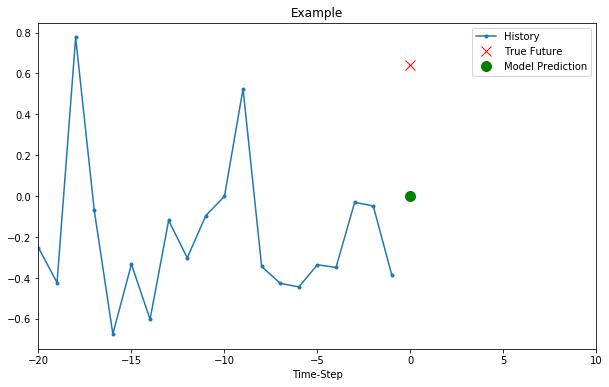

In [9]:
for x, y in train_set.take(1):
    plot = plot_prediction([x[0].numpy(), y[0].numpy(),0] , 'Example')
    plot.show()

## Define model

In [10]:
def define_model():

    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)

    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding="causal",
                          activation="relu",
                          input_shape=[None, 1]),
      tf.keras.layers.LSTM(window_size, return_sequences=True),
      tf.keras.layers.LSTM(window_size, return_sequences=True),
      tf.keras.layers.Dense(30, activation="relu"),
      tf.keras.layers.Dense(10, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 400)

    ])
    
    return model

In [11]:
model = define_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 20)          4240      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
dense (Dense)                (None, None, 30)          630       
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

**Train with different learning rates**

In [12]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [13]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
18/18 [==============================] - 5s 267ms/step - loss: 4.5192 - mae: 4.9797
Epoch 2/100
18/18 [==============================] - 1s 68ms/step - loss: 3.9845 - mae: 4.4420
Epoch 3/100
18/18 [==============================] - 1s 66ms/step - loss: 3.4313 - mae: 3.8909
Epoch 4/100
18/18 [==============================] - 1s 70ms/step - loss: 2.9728 - mae: 3.4332
Epoch 5/100
18/18 [==============================] - 1s 69ms/step - loss: 2.6088 - mae: 3.0682
Epoch 6/100
18/18 [==============================] - 1s 67ms/step - loss: 2.3209 - mae: 2.7783
Epoch 7/100
18/18 [==============================] - 1s 67ms/step - loss: 2.0881 - mae: 2.5437
Epoch 8/100
18/18 [==============================] - 1s 67ms/step - loss: 1.8914 - mae: 2.3450
Epoch 9/100
18/18 [==============================] - 1s 69ms/step - loss: 1.7165 - mae: 2.1668
Epoch 10/100
18/18 [==============================

18/18 [==============================] - 1s 69ms/step - loss: 20.7397 - mae: 21.5945
Epoch 83/100
18/18 [==============================] - 1s 71ms/step - loss: 13.8437 - mae: 14.5877
Epoch 84/100
18/18 [==============================] - 1s 69ms/step - loss: 24.1194 - mae: 25.1890
Epoch 85/100
18/18 [==============================] - 1s 69ms/step - loss: 18.9026 - mae: 19.8459
Epoch 86/100
18/18 [==============================] - 1s 64ms/step - loss: 37.7677 - mae: 39.1857
Epoch 87/100
18/18 [==============================] - 1s 63ms/step - loss: 20.4484 - mae: 21.0126
Epoch 88/100
18/18 [==============================] - 1s 64ms/step - loss: 17.7210 - mae: 18.6038
Epoch 89/100
18/18 [==============================] - 1s 63ms/step - loss: 10.2934 - mae: 10.7353
Epoch 90/100
18/18 [==============================] - 1s 68ms/step - loss: 17.4953 - mae: 18.4080
Epoch 91/100
18/18 [==============================] - 1s 63ms/step - loss: 95.5130 - mae: 93.4678
Epoch 92/100
18/18 [=============

**Find best learning rate**

[1e-08, 0.0001, 0, 60]

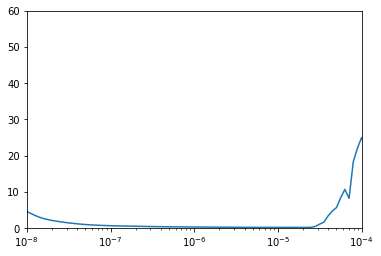

In [14]:
import matplotlib.pyplot as plt

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [15]:
min_index = np.argmin(np.array(history.history["loss"]))
lr = history.history['lr'][min_index]

In [16]:
#Best learning rate. WIth this value, the model overfits
lr

1.9952624e-05

**Train with best learning rate**

In [17]:
model = define_model()

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=20)

Epoch 1/20
18/18 [==============================] - 5s 269ms/step - loss: 1.9560 - mae: 2.4276
Epoch 2/20
18/18 [==============================] - 1s 71ms/step - loss: 0.5842 - mae: 0.9743
Epoch 3/20
18/18 [==============================] - 1s 76ms/step - loss: 0.4092 - mae: 0.7678
Epoch 4/20
18/18 [==============================] - 1s 69ms/step - loss: 0.3402 - mae: 0.6751
Epoch 5/20
18/18 [==============================] - 1s 69ms/step - loss: 0.3087 - mae: 0.6341
Epoch 6/20
18/18 [==============================] - 1s 69ms/step - loss: 0.2919 - mae: 0.6116
Epoch 7/20
18/18 [==============================] - 1s 73ms/step - loss: 0.2803 - mae: 0.5961
Epoch 8/20
18/18 [==============================] - 1s 68ms/step - loss: 0.2707 - mae: 0.5834
Epoch 9/20
18/18 [==============================] - 1s 69ms/step - loss: 0.2621 - mae: 0.5721
Epoch 10/20
18/18 [==============================] - 1s 74ms/step - loss: 0.2543 - mae: 0.5616
Epoch 11/20
18/18 [==============================] - 1s 73

## Evaluate model

**Predict time series with the model**

In [18]:
def validation_dataset(series, window_size, batch_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [19]:
val_dataset = validation_dataset(x_valid, window_size, batch_size)

**Plot one prediction** 

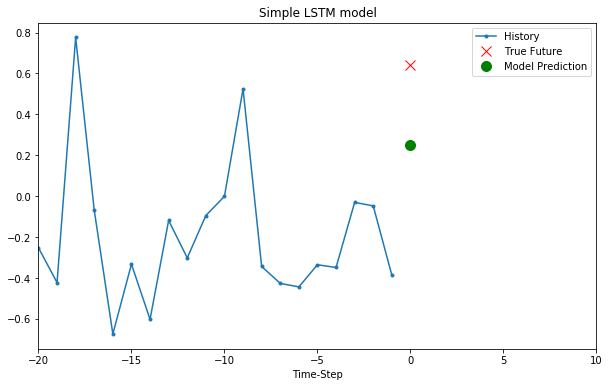

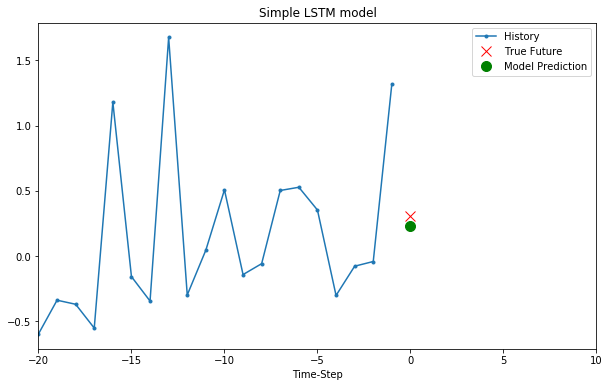

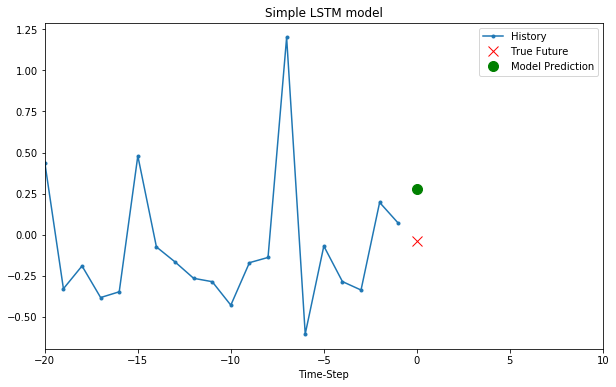

In [20]:
for x, y in train_set.take(3):
    prediction = model.predict(x)[0]
    plot = plot_prediction([x[0].numpy(), y[0].numpy(), prediction[0]] , 'Simple LSTM model')
    plot.show()

**Plot all prediction future**

In [21]:
def model_forecast(model, series, window_size, batch_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [22]:
x = np.concatenate((x_train, x_valid))

In [23]:
rnn_forecast = model_forecast(model, x, window_size, batch_size)

In [24]:
rnn_forecast = rnn_forecast[split_time-window_size+1:,-1,0]

In [25]:
rnn_forecast.shape

(1855,)

**Plot series**

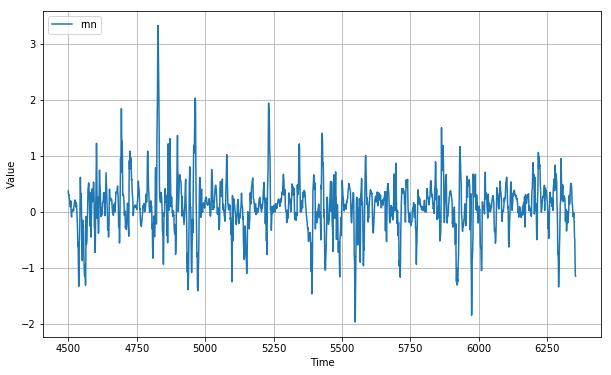

In [27]:
#plot_series(time_train, x_train)
plot_series(time_valid, [rnn_forecast], label="rnn")


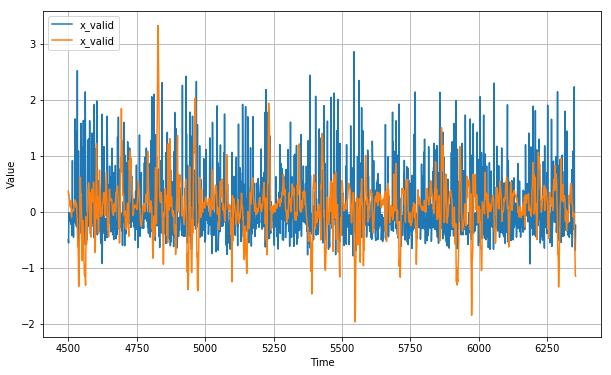

In [28]:
plot_series(time_valid, [x_valid, rnn_forecast], label="x_valid")

In [29]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy().mean()

0.5729164